In [53]:
# Installing all the dependencies
!pip install --upgrade ibm-watson
import cv2
from matplotlib import pyplot as plt
from pylab import rcParams

Requirement already up-to-date: ibm-watson in c:\users\njnis\anaconda3\lib\site-packages (4.1.0)


In [16]:
# Paste your API key for IBM Watson Visual Recognition below:
my_apikey = 'Your key goes here'

In [17]:
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
authenticator = IAMAuthenticator(my_apikey)

visrec = VisualRecognitionV3('2018-03-19', 
                             authenticator=authenticator)

In [13]:
# Downloading the dataset zip files from url 
import urllib.request

# Downloading Beagle dataset
urllib.request.urlretrieve("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/CV0101/Dataset/Burger.zip", 
                           "burger.zip")

# Downloading Husky dataset
urllib.request.urlretrieve("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/CV0101/Dataset/Fries.zip", 
                           "fries.zip")

# Downloading Golden Retriever dataset
urllib.request.urlretrieve("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/CV0101/Dataset/Pizza.zip", 
                           "pizza.zip") #note that we should remove any hyphens from the zip file name

('pizza.zip', <http.client.HTTPMessage at 0x125409cc808>)

In [19]:
# Creating a custom classifier with the three food classes
import json
with open('burger.zip', 'rb') as burger, \
     open('fries.zip', 'rb') as fries, \
     open('pizza.zip', 'rb') as pizza:
        response = visrec.create_classifier(name="FastFoodClassifier",
                                        positive_examples={'burger': burger, \
                                                           'fries': fries, \
                                                           'pizza': pizza})
print(json.dumps(response.get_result(), indent=2))

{
  "classifier_id": "FastFoodClassifier_1251050556",
  "name": "FastFoodClassifier",
  "status": "training",
  "owner": "7038d87b-a2a2-446e-bf89-44ccc61c11fc",
  "created": "2020-01-10T08:55:31.849Z",
  "updated": "2020-01-10T08:55:31.849Z",
  "classes": [
    {
      "class": "pizza"
    },
    {
      "class": "fries"
    },
    {
      "class": "burger"
    }
  ],
  "core_ml_enabled": true
}


In [39]:
def plt_image(image_url, size = (10,8)):

    # Downloads an image from a URL, and displays it in the notebook
    urllib.request.urlretrieve(image_url, "image.jpg") # downloads file as "image.jpg"
    image = cv2.imread("image.jpg")
    
    # If image is in color, then correct color coding from BGR to RGB
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    rcParams['figure.figsize'] = size[0], size[1] #set image display size

    plt.axis("off")
    plt.imshow(image, cmap="Greys_r")
    plt.show()

In [21]:
# Saving the classifier id
fast_food_classifier_id = response.get_result()["classifier_id"]

In [55]:
# Testing if the training is still going on
visrec.get_classifier(classifier_id=fast_food_classifier_id, verbose=True).get_result()['status']

'ready'

WARNING:   DO NOT PROCEED TILL THE STATUS SHOWS 'READY'

In [30]:
status=visrec.get_classifier(classifier_id=fast_food_classifier_id, verbose=True).get_result()['status']
while status!='ready':
    print('Still Training')
    status=visrec.get_classifier(classifier_id=fast_food_classifier_id, verbose=True).get_result()['status']

In [31]:
# Getting the results and publishing them
from pandas.io.json import json_normalize

def getdf_visrec(url, classifier_ids, apikey = my_apikey):
    
    json_result = visrec.classify(url=url,
                              threshold='0.6',
                              classifier_ids=classifier_ids).get_result()
    
    json_classes = json_result['images'][0]['classifiers'][0]['classes']
    
    df = json_normalize(json_classes).sort_values('score', ascending=False).reset_index(drop=True)
    
    return df

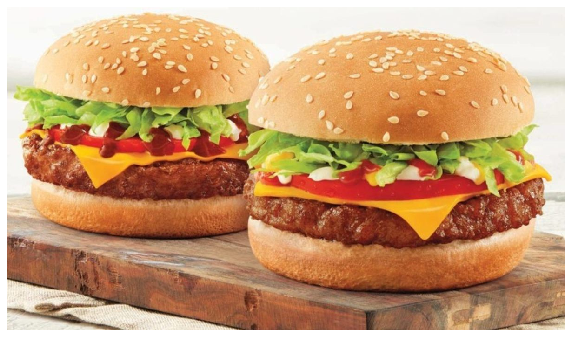

,class,score
0,burger,0.908


In [44]:
## BURGER
food_url='https://www.plantbasednews.org/.image/t_share/MTY1NTk1NzkyMTYyMzAxMjE1/image-placeholder-title.jpg'
plt_image(food_url)
getdf_visrec(food_url,classifier_ids=fast_food_classifier_id)

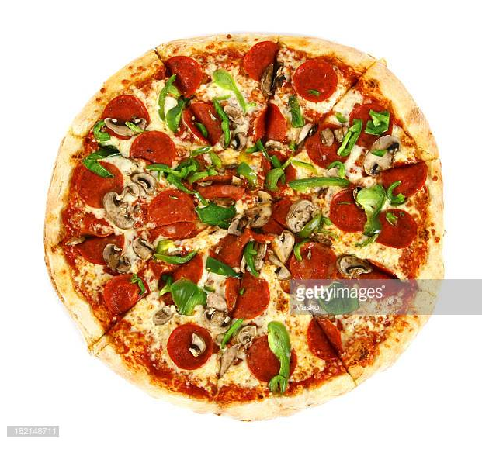

,class,score
0,pizza,0.847


In [45]:
## PIZZA
food_url='https://media.gettyimages.com/photos/pizza-from-the-top-deluxe-picture-id182148711?s=612x612'
plt_image(food_url)
getdf_visrec(food_url,classifier_ids=fast_food_classifier_id)

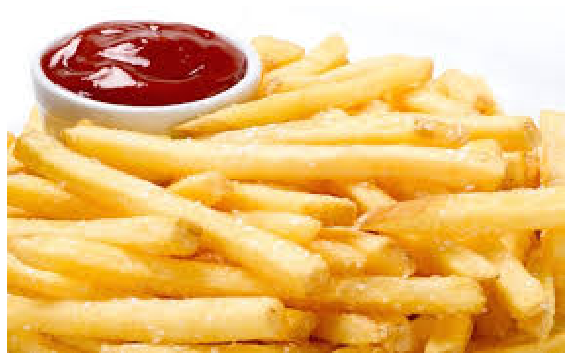

,class,score
0,fries,0.899


In [51]:
## FRIES
food_url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRWoj54WKArIvhkuz1PT-Sl_ONe-XeqW7gTWjNAWXOh41C6k2B9Gw&s'
plt_image(food_url)
getdf_visrec(food_url,classifier_ids=fast_food_classifier_id)

In [56]:
# This is to delete the classifier

mycid = 'FastFoodClassifier_1251050556' #the classifier id you want to delete
visrec.delete_classifier(classifier_id = mycid)